In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
import seaborn as sns


In [2]:
data = loadmat('./datasets/cover.mat')
X = np.array(data.get('X'))
y = np.array(data.get('y')).ravel().astype(int)

In [3]:
print(f"Zbiór danych cover: {X.shape[0]} próbek, {X.shape[1]} cech, {np.sum(y)} anomalii ({100 * np.mean(y):.2f}% outlierów)")
all_results = []


Zbiór danych cover: 286048 próbek, 10 cech, 2747 anomalii (0.96% outlierów)



=== Local Outlier Factor (LOF) ===

LOF (n_neighbors=5, contamination=0.01):
Macierz pomyłek:
 [[280517   2784]
 [  2670     77]]
AUC: 0.4374
Czas wykonania: 2.4630 s

LOF (n_neighbors=5, contamination=0.05):
Macierz pomyłek:
 [[269339  13962]
 [  2406    341]]
AUC: 0.4374
Czas wykonania: 2.4410 s

LOF (n_neighbors=5, contamination=0.1):
Macierz pomyłek:
 [[255256  28045]
 [  2187    560]]
AUC: 0.4374
Czas wykonania: 2.4599 s

LOF (n_neighbors=10, contamination=0.01):
Macierz pomyłek:
 [[280534   2767]
 [  2653     94]]
AUC: 0.4332
Czas wykonania: 3.3252 s

LOF (n_neighbors=10, contamination=0.05):
Macierz pomyłek:
 [[269372  13929]
 [  2373    374]]
AUC: 0.4332
Czas wykonania: 3.3080 s

LOF (n_neighbors=10, contamination=0.1):
Macierz pomyłek:
 [[255291  28010]
 [  2152    595]]
AUC: 0.4332
Czas wykonania: 3.2817 s

LOF (n_neighbors=20, contamination=0.01):
Macierz pomyłek:
 [[280580   2721]
 [  2607    140]]
AUC: 0.4403
Czas wykonania: 4.7885 s

LOF (n_neighbors=20, contamination=0.

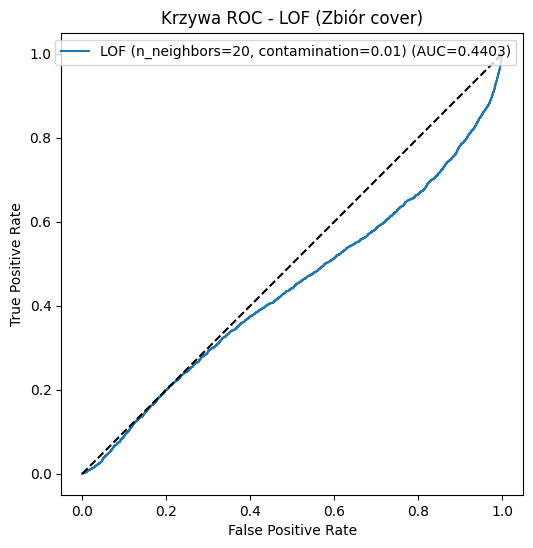

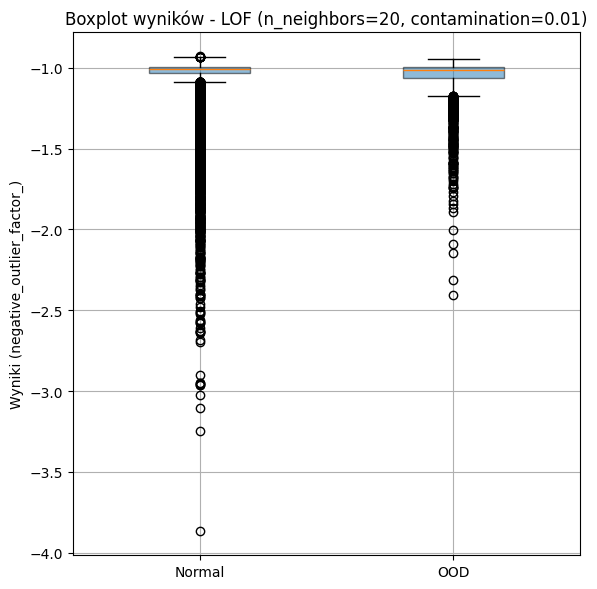

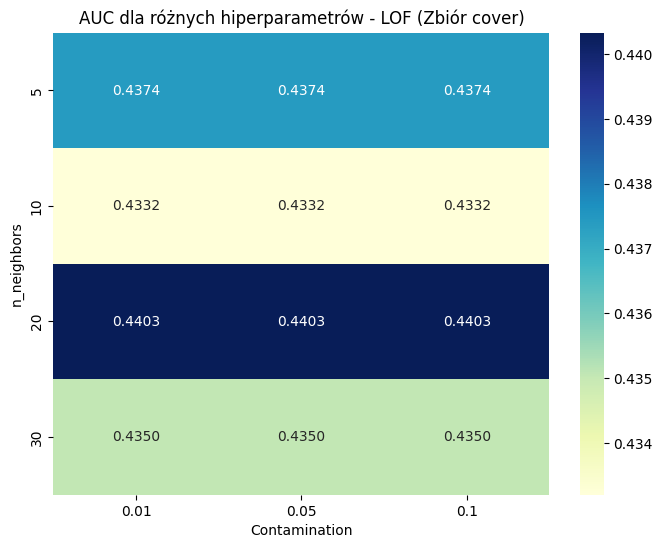

In [ ]:
# 1. LOF
print("\n=== Local Outlier Factor (LOF) ===")
n_neighbors_list = [5, 10, 20, 30, 50]
contamination_list = [0.01, 0.05, 0.1]
lof_results = []

for n_neighbors in n_neighbors_list:
    for contamination in contamination_list:
        start_time = time.time()
        model_name = f"LOF (n_neighbors={n_neighbors}, contamination={contamination})"
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)

        y_pred = lof.fit_predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = lof.negative_outlier_factor_
        normal_scores = scores[y == 0]
        ood_scores = scores[y == 1]

        cm = confusion_matrix(y, y_pred)

        fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        lof_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'n_neighbors': n_neighbors,
            'contamination': contamination
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_lof = max(lof_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego LOF
plt.figure(figsize=(6, 6))
plt.plot(best_lof['fpr'], best_lof['tpr'], label=f"{best_lof['model_name']} (AUC={best_lof['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - LOF (Zbiór cover)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego LOF
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_lof['normal_scores'], best_lof['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C0', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_lof["model_name"]}')
ax.set_ylabel('Wyniki (negative_outlier_factor_)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów LOF
auc_matrix = np.zeros((len(n_neighbors_list), len(contamination_list)))
for result in lof_results:
    i = n_neighbors_list.index(result['n_neighbors'])
    j = contamination_list.index(result['contamination'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=contamination_list, yticklabels=n_neighbors_list, cmap='YlGnBu')
plt.xlabel('Contamination')
plt.ylabel('n_neighbors')
plt.title('AUC dla różnych hiperparametrów - LOF (Zbiór cover)')
plt.show()


=== Isolation Forest ===

Isolation Forest (n_estimators=50, contamination=0.01):
Macierz pomyłek:
 [[280948   2353]
 [  2239    508]]
AUC: 0.9238
Czas wykonania: 1.0179 s

Isolation Forest (n_estimators=50, contamination=0.05):
Macierz pomyłek:
 [[270313  12988]
 [  1432   1315]]
AUC: 0.9238
Czas wykonania: 1.0198 s

Isolation Forest (n_estimators=50, contamination=0.1):
Macierz pomyłek:
 [[256693  26608]
 [   750   1997]]
AUC: 0.9238
Czas wykonania: 1.0075 s

Isolation Forest (n_estimators=100, contamination=0.01):
Macierz pomyłek:
 [[280734   2567]
 [  2453    294]]
AUC: 0.9085
Czas wykonania: 1.9484 s

Isolation Forest (n_estimators=100, contamination=0.05):
Macierz pomyłek:
 [[270000  13301]
 [  1745   1002]]
AUC: 0.9085
Czas wykonania: 1.9429 s

Isolation Forest (n_estimators=100, contamination=0.1):
Macierz pomyłek:
 [[256453  26848]
 [   990   1757]]
AUC: 0.9085
Czas wykonania: 1.9491 s

Isolation Forest (n_estimators=200, contamination=0.01):
Macierz pomyłek:
 [[280690   2611

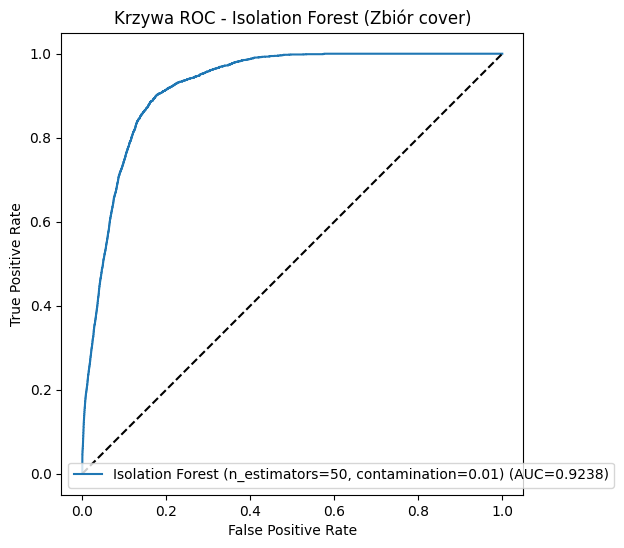

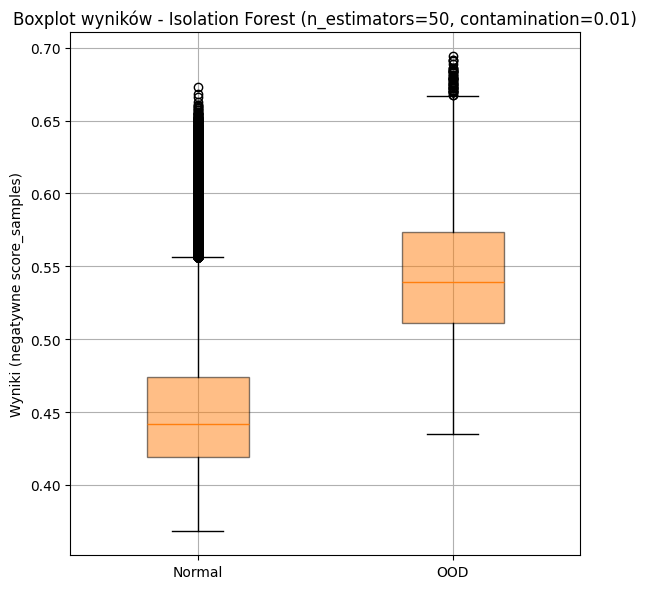

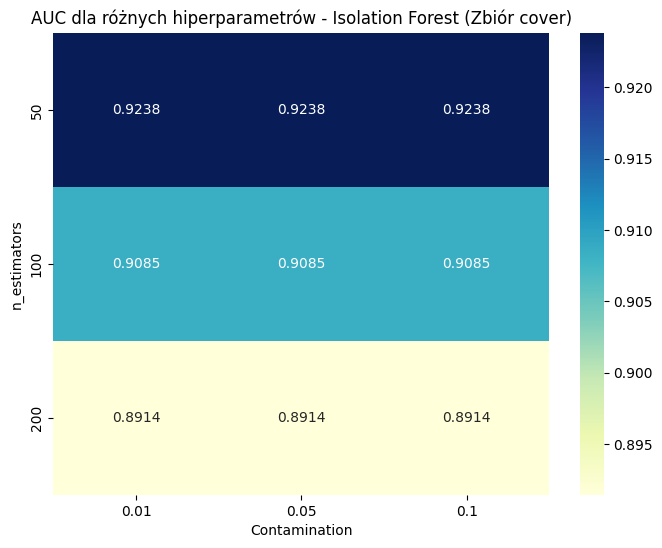

In [ ]:
# 2. Isolation Forest
print("\n=== Isolation Forest ===")
n_estimators_list = [50, 100, 200]
contamination_list = [0.01, 0.05, 0.1]
iso_results = []

for n_estimators in n_estimators_list:
    for contamination in contamination_list:
        start_time = time.time()

        model_name = f"Isolation Forest (n_estimators={n_estimators}, contamination={contamination})"
        iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)

        y_pred = iso_forest.fit_predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = -iso_forest.score_samples(X)
        normal_scores = scores[y == 0]
        ood_scores = scores[y == 1]
        
        cm = confusion_matrix(y, y_pred)

        fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        iso_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'n_estimators': n_estimators,
            'contamination': contamination
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_iso = max(iso_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego Isolation Forest
plt.figure(figsize=(6, 6))
plt.plot(best_iso['fpr'], best_iso['tpr'], label=f"{best_iso['model_name']} (AUC={best_iso['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Isolation Forest (Zbiór cover)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego Isolation Forest
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_iso['normal_scores'], best_iso['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C1', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_iso["model_name"]}')
ax.set_ylabel('Wyniki (negatywne score_samples)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów Isolation Forest
auc_matrix = np.zeros((len(n_estimators_list), len(contamination_list)))
for result in iso_results:
    i = n_estimators_list.index(result['n_estimators'])
    j = contamination_list.index(result['contamination'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=contamination_list, yticklabels=n_estimators_list, cmap='YlGnBu')
plt.xlabel('Contamination')
plt.ylabel('n_estimators')
plt.title('AUC dla różnych hiperparametrów - Isolation Forest (Zbiór cover)')
plt.show()



Podpróbkowany zbiór dla One-Class SVM: 28605 próbek, 275 anomalii (0.96% outlierów)

=== One-Class SVM ===

One-Class SVM (nu=0.01, gamma=0.001):
Macierz pomyłek:
 [[ 8942 19388]
 [  115   160]]
AUC: 0.4367
Czas wykonania: 199.4428 s

One-Class SVM (nu=0.01, gamma=0.01):
Macierz pomyłek:
 [[21277  7053]
 [  225    50]]
AUC: 0.4679
Czas wykonania: 215.3776 s

One-Class SVM (nu=0.01, gamma=scale):
Macierz pomyłek:
 [[28064   266]
 [  255    20]]
AUC: 0.8406
Czas wykonania: 1.4778 s

One-Class SVM (nu=0.05, gamma=0.001):
Macierz pomyłek:
 [[11360 16970]
 [  115   160]]
AUC: 0.4965
Czas wykonania: 227.3723 s

One-Class SVM (nu=0.05, gamma=0.01):
Macierz pomyłek:
 [[21629  6701]
 [  221    54]]
AUC: 0.4698
Czas wykonania: 232.7098 s

One-Class SVM (nu=0.05, gamma=scale):
Macierz pomyłek:
 [[26954  1376]
 [  222    53]]
AUC: 0.8142
Czas wykonania: 7.3536 s

One-Class SVM (nu=0.1, gamma=0.001):
Macierz pomyłek:
 [[11336 16994]
 [  125   150]]
AUC: 0.4557
Czas wykonania: 215.3393 s

One-Class

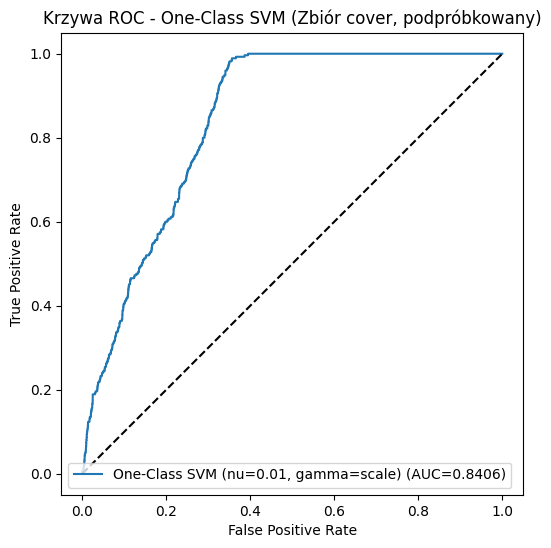

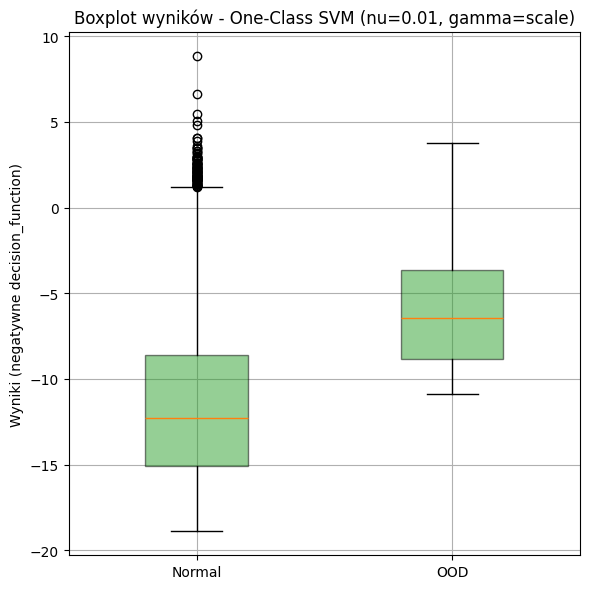

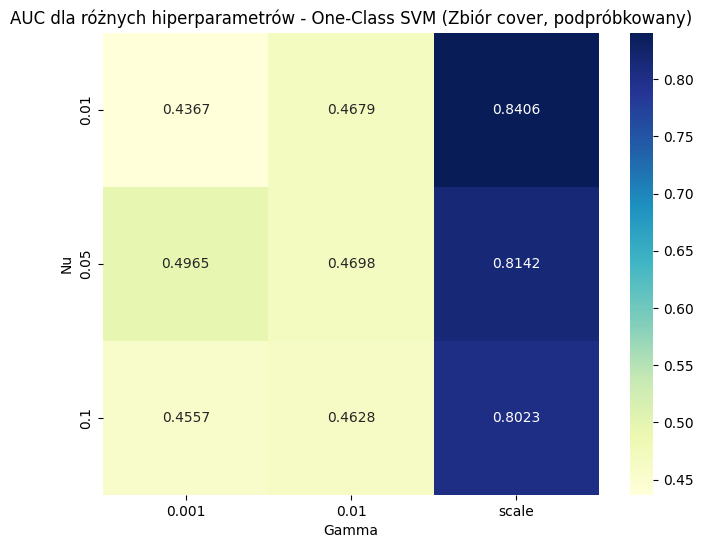

In [ ]:
# zmniejszenie liczby probek, za dlugo liczylo :(
from sklearn.utils import resample
X_sub, y_sub = resample(X, y, n_samples=28605, stratify=y, random_state=42)
print(f"\nPodpróbkowany zbiór dla One-Class SVM: {X_sub.shape[0]} próbek, {np.sum(y_sub)} anomalii ({100 * np.mean(y_sub):.2f}% outlierów)")

# One-Class SVM
print("\n=== One-Class SVM ===")
nu_list = [0.01, 0.05, 0.1]
gamma_list = [0.001, 0.01, 'scale']
svm_results = []

for nu in nu_list:
    for gamma in gamma_list:
        start_time = time.time()

        model_name = f"One-Class SVM (nu={nu}, gamma={gamma})"
        ocsvm = OneClassSVM(nu=nu, gamma=gamma, kernel='rbf')

        y_pred = ocsvm.fit_predict(X_sub)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = -ocsvm.decision_function(X_sub)
        normal_scores = scores[y_sub == 0]
        ood_scores = scores[y_sub == 1]

        cm = confusion_matrix(y_sub, y_pred)

        fpr, tpr, _ = roc_curve(y_sub, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        svm_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'nu': nu,
            'gamma': gamma
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_svm = max(svm_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego One-Class SVM
plt.figure(figsize=(6, 6))
plt.plot(best_svm['fpr'], best_svm['tpr'], label=f"{best_svm['model_name']} (AUC={best_svm['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - One-Class SVM (Zbiór cover)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego One-Class SVM
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_svm['normal_scores'], best_svm['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C2', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_svm["model_name"]}')
ax.set_ylabel('Wyniki (negatywne decision_function)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów One-Class SVM
auc_matrix = np.zeros((len(nu_list), len(gamma_list)))
for result in svm_results:
    i = nu_list.index(result['nu'])
    j = gamma_list.index(result['gamma'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=gamma_list, yticklabels=nu_list, cmap='YlGnBu')
plt.xlabel('Gamma')
plt.ylabel('Nu')
plt.title('AUC dla różnych hiperparametrów - One-Class SVM (Zbiór cover)')
plt.show()

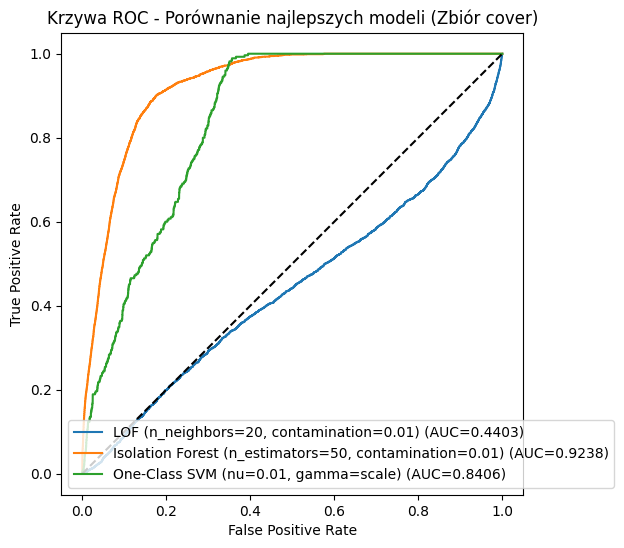


Podsumowanie wyników:
                                                Model       AUC  \
0             LOF (n_neighbors=5, contamination=0.01)  0.437421   
1             LOF (n_neighbors=5, contamination=0.05)  0.437421   
2              LOF (n_neighbors=5, contamination=0.1)  0.437421   
3            LOF (n_neighbors=10, contamination=0.01)  0.433202   
4            LOF (n_neighbors=10, contamination=0.05)  0.433202   
5             LOF (n_neighbors=10, contamination=0.1)  0.433202   
6            LOF (n_neighbors=20, contamination=0.01)  0.440333   
7            LOF (n_neighbors=20, contamination=0.05)  0.440333   
8             LOF (n_neighbors=20, contamination=0.1)  0.440333   
9            LOF (n_neighbors=30, contamination=0.01)  0.435050   
10           LOF (n_neighbors=30, contamination=0.05)  0.435050   
11            LOF (n_neighbors=30, contamination=0.1)  0.435050   
12  Isolation Forest (n_estimators=50, contaminati...  0.923829   
13  Isolation Forest (n_estimators=50, 

In [7]:
# Porównawczy wykres ROC dla wszystkich najlepszych modeli
plt.figure(figsize=(8, 6))
plt.plot(best_lof['fpr'], best_lof['tpr'], label=f"{best_lof['model_name']} (AUC={best_lof['roc_auc']:.4f})")
plt.plot(best_iso['fpr'], best_iso['tpr'], label=f"{best_iso['model_name']} (AUC={best_iso['roc_auc']:.4f})")
plt.plot(best_svm['fpr'], best_svm['tpr'], label=f"{best_svm['model_name']} (AUC={best_svm['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Porównanie najlepszych modeli (Zbiór cover)')
plt.legend()
plt.axis('square')
plt.show()

# Zapis wyników do DataFrame
results_df = pd.DataFrame(all_results)
print("\nPodsumowanie wyników:")
print(results_df)